*Problem 1.1*
Visulize Mandelbrot set.

### Mandelbrot Set

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from time import time
from scipy.stats import norm, t
from scipy.stats import qmc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [194]:
def mandelbrot(c, z):
    return z**2 + c

def stability(c, max_iter):
    z = 0
    for i in range(max_iter):
        z = mandelbrot(c, z)
        if abs(z) > 2:
            return i
    return max_iter

def mandelbrot_set(width, height, real_range, imag_range, max_iter):
    real_vals = np.linspace(real_range[0], real_range[1], width)
    imag_vals = np.linspace(imag_range[0], imag_range[1], height)
    
    image = np.empty((width, height))
    for i in range(width):
        for j in range(height):
            image[i, j] = stability(real_vals[i] + 1j*imag_vals[j], max_iter)
    return image

# Compute the Mandelbrot set
resolution = 1000
max_iter_1 = 200
width = resolution
height = resolution
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
image = mandelbrot_set(width, height, real_range, imag_range, max_iter=max_iter_1)
    

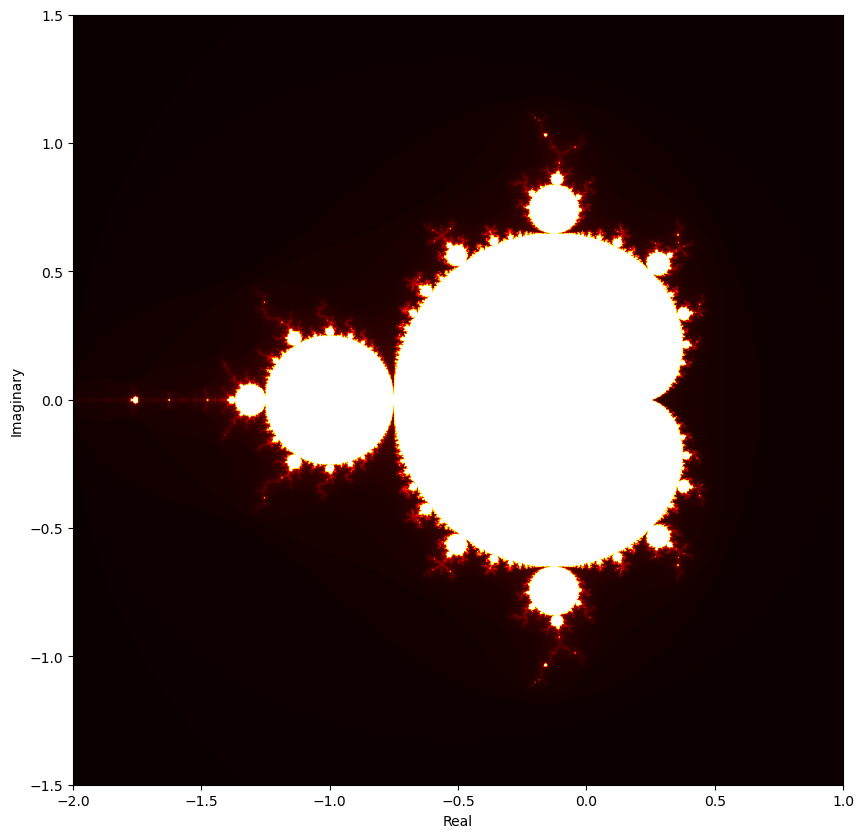

In [195]:
# Visualize with interpolation
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap='hot', interpolation='bilinear', extent=[-2, 1, -1.5, 1.5])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

In [196]:
from scipy.interpolate import pchip_interpolate
from matplotlib.colors import LinearSegmentedColormap

def custom_colourmap():
    #set up the control points for your gradient
    yR_observed = [0, 0,32,237, 255, 0, 0, 32]
    yG_observed = [2, 7, 107, 255, 170, 2, 7, 107]
    yB_observed = [0, 100, 203, 255, 0, 0, 100, 203]

    x_observed = [-.1425, 0, .16, .42, .6425, .8575, 1, 1.16]

    #Create the arrays with the interpolated values
    x = np.linspace(min(x_observed), max(x_observed), num=1000)
    yR = pchip_interpolate(x_observed, yR_observed, x)
    yG = pchip_interpolate(x_observed, yG_observed, x)
    yB = pchip_interpolate(x_observed, yB_observed, x)

    #Convert them back to python lists
    x = list(x)
    yR = list(yR)
    yG = list(yG)
    yB = list(yB)

    #Find the indexs where x crosses 0 and crosses 1 for slicing
    start = 0
    end = 0
    for i in x:
        if i > 0:
            start = x.index(i)
            break

    for i in x:
        if i > 1:
            end = x.index(i)
            break

    #Slice away the helper data in the begining and end leaving just 0 to 1
    x = x[start:end]
    yR = yR[start:end]
    yG = yG[start:end]
    yB = yB[start:end]

    # Normalize the color values to the [0, 1] range
    yR = np.array(yR) / 255.0
    yG = np.array(yG) / 255.0
    yB = np.array(yB) / 255.0

    # Append 0 to the end of yR, yG, and yB
    yR = np.append(yR, 0.0)
    yG = np.append(yG, 0.0)
    yB = np.append(yB, 0.0)

    # Create a custom colormap from the interpolated color values
    colors = np.column_stack((yR, yG, yB))  # Combine R, G, and B values
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
    
    return cmap


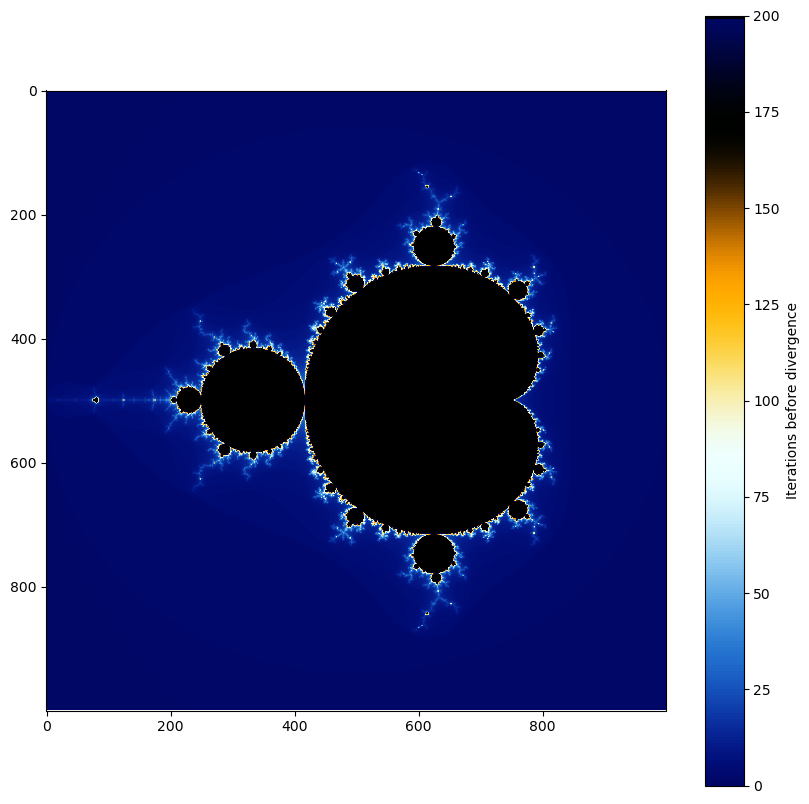

In [197]:
cmap = custom_colourmap()

# Create a figure and plot the data using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap=cmap)
plt.colorbar().set_label('Iterations before divergence')
plt.show()

## Question 2

Analyze how $i$ influence $A_{is}$ when $s$ is 100000(very large).

In [198]:
# Define the pure random sampling function
def pure_random_sampling(num_samples, real_range, imag_range):
    real_samples = np.random.uniform(real_range[0], real_range[1], num_samples)
    imag_samples = np.random.uniform(imag_range[0], imag_range[1], num_samples)
    return real_samples + 1j * imag_samples

# Define a function to estimate the area of the Mandelbrot set using sampling
def estimate_area(samples, max_iter):
    inside_count = 0
    for c in samples:
        if stability(c, max_iter) == max_iter:
            inside_count += 1
    area = 9 * inside_count / len(samples)
    return area

# Define a function to calculate the convergence of areas for different values of max_iter
def convergence_curve(samples, max_iter_range):
    areas = []
    times = []
    
    for max_iter in max_iter_range:
        start_time = time()
        area = estimate_area(samples, max_iter)
        times.append(time() - start_time)
        areas.append(area)
    
    return areas, times

In [199]:
# Set parameters for the area estimation
num_samples = 100000
max_iter_range_adjusted = np.arange(100, 6000, 100)
real_range = [-2, 1]
imag_range = [-1.5, 1.5]

# Run the pure random sampling once and store the samples
pure_random_samples = pure_random_sampling(num_samples, real_range, imag_range)

# Calculate the convergence curve for pure random sampling with adjusted range
areas_pure_random, times_pure_random = convergence_curve(
    pure_random_samples,
    max_iter_range_adjusted
)


### Find the smallest i that meets the desired_relative_error(0.1%)

In [200]:
# Initialize variables to store the minimum i that meets the condition
# and the corresponding relative error
min_i = None
min_i_relative_error = None
Af = areas_pure_random[-1]
desired_relative_error = 0.001
# Track whether the desired relative error condition has been met
condition_met = False

# Find the minimum i that satisfies the desired relative error
# and ensure that all larger i values also have a relative error less than the threshold
for i, area in enumerate(areas_pure_random):
    relative_error = abs(area - Af) / Af
    
    # Check if the current relative error meets the desired condition
    if relative_error <= desired_relative_error:
        if not condition_met:  # Condition met for the first time
            min_i = max_iter_range_adjusted[i]
            min_i_relative_error = relative_error
            min_i_index = i
            condition_met = True
        else:
            # Check if any subsequent i has a relative error greater than the threshold
            if relative_error > desired_relative_error:
                # If a larger i has a higher relative error, reset the condition
                condition_met = False
                min_i = None
                min_i_relative_error = None
                min_i_index = 9999

# Output results
  # Assume the last area is the final area Af
if min_i is not None:
    print(f"The minimum i that satisfies the desired relative error of {desired_relative_error*100}% is {min_i}.")
    print(f"The relative error achieved is {min_i_relative_error*100}%.")  
    print(f"The area at this i is {areas_pure_random[min_i_index]}.")
else:
    print("No minimum i found that satisfies the relative error condition for all subsequent i values.")

print(f"$A_f$ is {Af}")


The minimum i that satisfies the desired relative error of 0.1% is 2300.
The relative error achieved is 0.09575677778441995%.
The area at this i is 1.50525.
$A_f$ is 1.50381


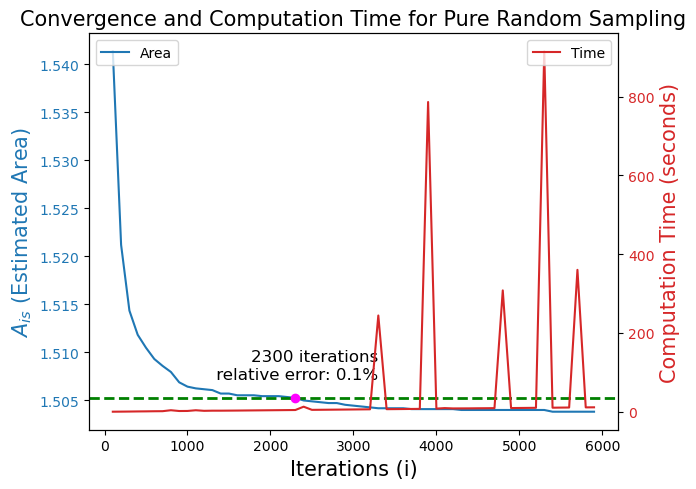

In [201]:
# Plotting
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'tab:blue'
ax1.set_xlabel('Iterations (i)', fontsize=15)
ax1.set_ylabel(r'$A_{is}$ (Estimated Area)', color=color, fontsize=15)
ax1.plot(max_iter_range_adjusted, areas_pure_random, label='Area', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Computation Time (seconds)', color=color, fontsize=15)
ax2.plot(max_iter_range_adjusted, times_pure_random, label='Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Convergence and Computation Time for Pure Random Sampling', fontsize = 15)

# Add a horizontal line to indicate the minimum number of iterations to satisfy the desired relative error
ax1.axhline(y=areas_pure_random[min_i_index], color='green', linestyle='--', linewidth=2)

# Annotate the minimum number of iterations and relative error
relative_error_percent = min_i_relative_error * 100
# Add a magenta point to mark the minimum i
ax1.scatter(min_i, areas_pure_random[min_i_index], color='magenta', zorder=5)
# Add text annotation next to the point
ax1.annotate(f'{min_i} iterations\n relative error: {relative_error_percent:.1f}%', 
             xy=(min_i, areas_pure_random[min_i_index]), 
             xytext=(min_i + 1000, areas_pure_random[min_i_index] + 0.002), # slight offset for readability
             fontsize=12,
             horizontalalignment='right')
plt.tight_layout()

plt.savefig("2.1 Smallest i.jpg", dpi=300)
plt.show()


### Upon different s
Since we are not going to sample more than 20000 points in Q2 and Q3, below we choose num_samples = [10000, 20000, 100000] to see if the min_i we find using the same method as above will have big differences.

The reason why we choose bigger s is because we want to control the influence of sampling stochasticity. Bigger s means higher chances to sample points that are hard to determine whether it is in or out of the Mandelbrot Set.

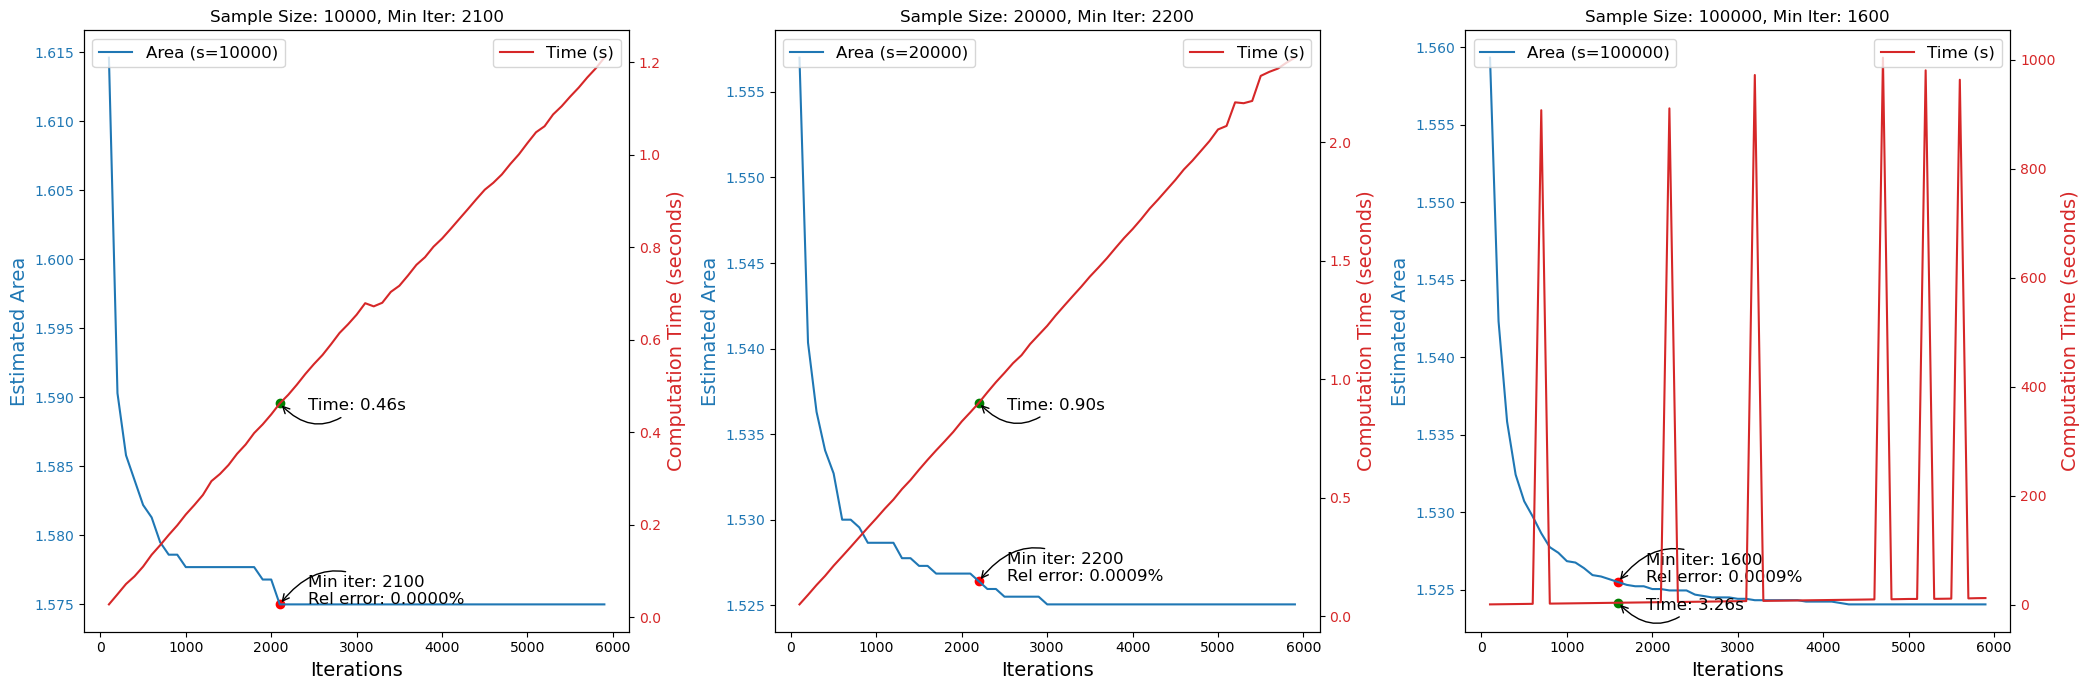

In [202]:
def find_min_iterations(areas, desired_rel_error, iter_range, Af):
    for i, area in enumerate(areas):
        relative_error = abs(area - Af) / Af
        if relative_error <= desired_rel_error:
            return iter_range[i], relative_error, i
    return None, None, None

def convergence_analysis_and_plotting(sample_size, max_iter_range, real_range, imag_range, desired_rel_error, ax):
    samples = pure_random_sampling(sample_size, real_range, imag_range)
    areas, times = convergence_curve(samples, max_iter_range)

    # Plot area convergence
    ax1 = ax
    ax1.plot(max_iter_range, areas, label=f'Area (s={sample_size})', color='tab:blue')
    ax1.set_xlabel('Iterations', fontsize = 14)
    ax1.set_ylabel('Estimated Area', color='tab:blue', fontsize = 14)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left', fontsize = 12)

    # Plot computation time
    ax2 = ax1.twinx()  
    ax2.plot(max_iter_range, times, label='Time (s)', color='tab:red')
    ax2.set_ylabel('Computation Time (seconds)', color='tab:red', fontsize = 14)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right', fontsize = 12)

    # Find and annotate the minimum iteration point
    Af = areas[-1]  # Final area estimate
    min_i, min_i_relative_error, min_i_index = find_min_iterations(areas, desired_rel_error, max_iter_range, Af)
    if min_i is not None:
        ax1.scatter(min_i, areas[min_i_index], color='red')
        ax1.annotate(f'Min iter: {min_i}\nRel error: {min_i_relative_error:.4f}%',
                    xy=(min_i, areas[min_i_index]), xytext=(20, 0), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5'), fontsize = 12)
        ax2.scatter(min_i, times[min_i_index], color='green')
        ax2.annotate(f'Time: {times[min_i_index]:.2f}s',
                    xy=(min_i, times[min_i_index]), xytext=(20, -5), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.5'), fontsize = 12)

    return min_i, min_i_relative_error

real_range = [-2, 1]
imag_range = [-1.5, 1.5]
sample_sizes = [10000, 20000, 100000]
max_iter_range = np.arange(100, 6000, 100)
desired_relative_error = 0.001

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
for i, sample_size in enumerate(sample_sizes):
    min_i, min_i_rel_error = convergence_analysis_and_plotting(
        sample_size, max_iter_range, real_range, imag_range,
        desired_relative_error, axes[i]
    )
    axes[i].set_title(f'Sample Size: {sample_size}, Min Iter: {min_i}')

plt.tight_layout()
plt.savefig("2.10 Convergence_Analysis.jpg", dpi=300)
plt.show()

### Find mean for min_i when s = 100000

In [204]:
# Parameters for the area estimation
num_samples = 100000
max_iter_range_adjusted = np.arange(100, 6000, 100)
real_range = [-2, 1]
imag_range = [-1.5, 1.5]


# Run 10 times and calculate min iterations
min_iterations_results = []
for _ in range(10):
    pure_random_samples = pure_random_sampling(num_samples, real_range, imag_range)
    areas_pure_random, times_pure_random = convergence_curve(pure_random_samples, max_iter_range_adjusted)
    Af = areas_pure_random[-1]
    min_i, _, _ = find_min_iterations(areas_pure_random, 0.001, max_iter_range_adjusted, Af)
    min_iterations_results.append(min_i)
    print(f"Min iterations for run: {min_i}")

# Calculate the average of the minimum iterations
average_min_iterations = np.mean(min_iterations_results)
print(average_min_iterations)
max_iter = average_min_iterations

Min iterations for run: 1500
Min iterations for run: 1900
Min iterations for run: 1500
Min iterations for run: 1400
Min iterations for run: 1800
Min iterations for run: 1900
Min iterations for run: 1600
Min iterations for run: 1800
Min iterations for run: 1600
Min iterations for run: 1600
1660.0


### Confidence Interval Analysis using CLT on i
We try to use CLT on different i to see if the Ais will converge when i increases.

In [ ]:
# Define the function to encapsulate the confidence interval calculation
def calculate_confidence_intervals_for_i(sampling_method, sample_sizes, real_range, imag_range, n, iterations):
    conf_interval_radii = []
    mean_areas = []
    times = [] # stores the time each s used to calculate the confidence intervals and sample mean values
    
    # Perform the area estimation for each sample size
    for i in iterations:
        start_time = time()  # start time
        area_estimates = []
        samples = sampling_method(sample_sizes, real_range, imag_range)

        for _ in range(n):
            area = estimate_area(samples, i)
            area_estimates.append(area)

        # Calculate the mean and standard deviation of the area estimates
        mean_area_estimated = np.mean(area_estimates)
        mean_areas.append(mean_area_estimated)
        std_area_estimated = np.std(area_estimates, ddof=1)

        # Calculate the 99% confidence interval radius
        z_score = norm.ppf(0.995)
        conf_radius = z_score * (std_area_estimated / np.sqrt(n))
        conf_interval_radii.append(conf_radius)

        end_time = time()  # end time
        times.append(end_time - start_time)  # compute the time

    return np.array(conf_interval_radii), np.array(mean_areas), np.array(times)

In [ ]:
# Example usage
sample_sizes = 10000
n = 50  # number of times to sample for each sample size
iterations = np.arange(100,5000,100)

# Calculate confidence intervals for pure random sampling
conf_intervals_pure_random, mean_areas_random, times_pure_random = calculate_confidence_intervals_for_i(
    pure_random_sampling, sample_sizes, real_range, imag_range, n, iterations
)

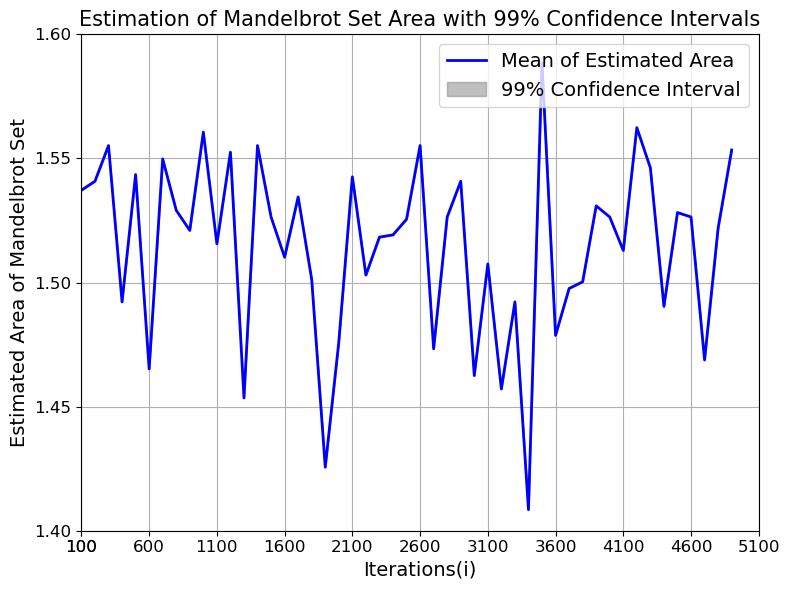

In [ ]:
# Plot the estimated area and confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(iterations, mean_areas_random, label='Mean of Estimated Area', color='blue', linewidth=2)
plt.fill_between(iterations, mean_areas_random - conf_intervals_pure_random, 
                 mean_areas_random + conf_intervals_pure_random, color='gray', alpha=0.5, 
                 label='99% Confidence Interval')

# Set chart title and labels with specified font sizes
plt.title('Estimation of Mandelbrot Set Area with 99% Confidence Intervals', fontsize=15)
plt.xlabel('Iterations(i)', fontsize=14)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=14)

# Specify font sizes for legend and grid
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)

# Set the x and y axis limits to ensure the origin is shown
plt.xlim(left=iterations[0], right=iterations[-1])
plt.ylim(bottom=min(mean_areas_random - conf_intervals_pure_random), top=max(mean_areas_random + conf_intervals_pure_random))

# Customize the tick marks font size and set specific ticks on x-axis
ax = plt.gca()  # Get the current Axes instance
ax.set_xticks([iterations[0]] + list(range(100, iterations[-1]+500, 500)))  # Set specific x-ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], num=5))  # Set y-ticks to be less dense

# Customize the tick labels font size
ax.tick_params(axis='x', labelsize=12)  # Smaller font size for x-ticks
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("2.8 mean value and confidence intervals for i.jpg", dpi=300)
plt.show()

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/11700943.py:63: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x16aea5b10> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/11700943.py:63: UserWarning: The label '_child2' of <matplotlib.lines.Line2D object at 0x16ac08c90> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/11700943.py:63: UserWarning: The label '_child4' of <matplotlib.lines.Line2D object at 0x16ad665d0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/11700943.py:63: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x16a8b4a50> starts with '_'. It is thus excluded from the legend.
 

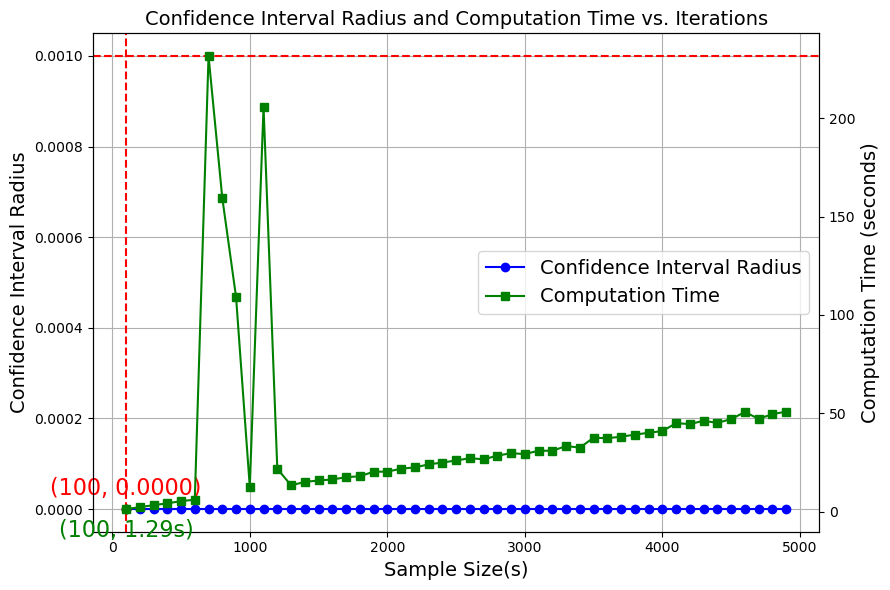

In [ ]:
def mark_min_confidence_interval_time_for_i(ax, ax2, iterations, conf_intervals, times, threshold=0.001, notationcolorx='r', notationcolory='g'):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return

    # Find the first index that satisfies the condition and ensure that all subsequent sample sizes also satisfy the condition
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_i_index = idx
            break
    else:
        print("No consecutive sample sizes meet the criterion.")
        return

    min_i = iterations[min_i_index]
    min_conf_interval = conf_intervals[min_i_index]
    min_time = times[min_i_index]

    ax.plot(min_i, min_conf_interval, notationcolorx+'o')  # Mark with circle
    ax.annotate(f'({min_i}, {min_conf_interval:.4f})', 
                 (min_i, min_conf_interval), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 fontsize=16,
                 ha='center',
                 color=notationcolorx)
    # Draw a vertical dashed line at the minimum sample size
    ax.axvline(x=min_i, color=notationcolorx, linestyle='--')

    # Mark the computation time at the minimum sample size
    ax2.plot(min_i, min_time, notationcolory+'o')  # Mark with circle
    ax2.annotate(f'({min_i}, {min_time:.2f}s)', 
                (min_i, min_time), 
                textcoords="offset points", 
                xytext=(0,-20), 
                fontsize=16,
                ha='center',
                color=notationcolory)

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(9, 6))
threshold = 0.001

# Plot the confidence interval on ax1
ax1.plot(iterations, conf_intervals_pure_random, marker='o', label='Confidence Interval Radius', color='blue')
ax1.axhline(y=threshold, color='red', linestyle='--')
ax1.set_xlabel('Sample Size(s)', fontsize=14)
ax1.set_ylabel('Confidence Interval Radius', fontsize=14)
ax1.set_title('Confidence Interval Radius and Computation Time vs. Iterations', fontsize=14)

# Use another y-axis for the computation time
ax2 = ax1.twinx()  
ax2.plot(iterations, times_pure_random, marker='s', label='Computation Time', color='green')
ax2.set_ylabel('Computation Time (seconds)', fontsize=14)

# Mark the minimum confidence interval that meets the threshold
mark_min_confidence_interval_time_for_i(ax1, ax2, iterations, conf_intervals_pure_random, times_pure_random)

# Handle legends for both axes
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=14)

ax1.grid(True)
plt.tight_layout()
plt.savefig("2.4 confidence_interval_and_time_combined_for_i.jpg", dpi=300)
plt.show()

The result is not significant.

### Use i = min_iter to plot Ais and relative error upon different s
This i varies. Above is 2300, but for different runs, we can get different min_i.

In [208]:
# Define the parameters for the area estimation
num_samples_start = 1000
num_samples_max = 100000
desired_d = 0.001
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
max_iter = int(average_min_iterations)

# Initialize variables for the iterative process
num_samples = num_samples_start
Am_estimations = []
relative_errors = []
sample_sizes = []

# Main iterative process
while num_samples <= num_samples_max:
    # Generate samples and estimate area
    samples = pure_random_sampling(num_samples, real_range, imag_range)
    current_area = estimate_area(samples, max_iter)
    
    # Assume Am is the area estimated with the maximum number of samples
    if num_samples == num_samples_max:
        Am = current_area
    
    # Calculate relative error
    relative_error = abs(Am - current_area) / Am
    relative_errors.append(relative_error)
    Am_estimations.append(current_area)
    sample_sizes.append(num_samples)
    
    print(f"Number of samples: {num_samples}, Estimated Area: {current_area}, Relative Error: {relative_error}")
    
    # Update num_samples for next iteration
    num_samples += 1000

Number of samples: 1000, Estimated Area: 1.512, Relative Error: 0.0016097299230906365
Number of samples: 2000, Estimated Area: 1.575, Relative Error: 0.043343468669886046
Number of samples: 3000, Estimated Area: 1.497, Relative Error: 0.008326874540432024
Number of samples: 4000, Estimated Area: 1.54125, Relative Error: 0.02098610862695995
Number of samples: 5000, Estimated Area: 1.53, Relative Error: 0.013533655279317916
Number of samples: 6000, Estimated Area: 1.4655, Relative Error: 0.0291937439138298
Number of samples: 7000, Estimated Area: 1.467, Relative Error: 0.02820008346747749
Number of samples: 8000, Estimated Area: 1.549125, Relative Error: 0.02620282597030943
Number of samples: 9000, Estimated Area: 1.54, Relative Error: 0.02015805825499974
Number of samples: 10000, Estimated Area: 1.4877, Relative Error: 0.014487569307816169
Number of samples: 11000, Estimated Area: 1.476, Relative Error: 0.022238120789363925
Number of samples: 12000, Estimated Area: 1.47375, Relative Err

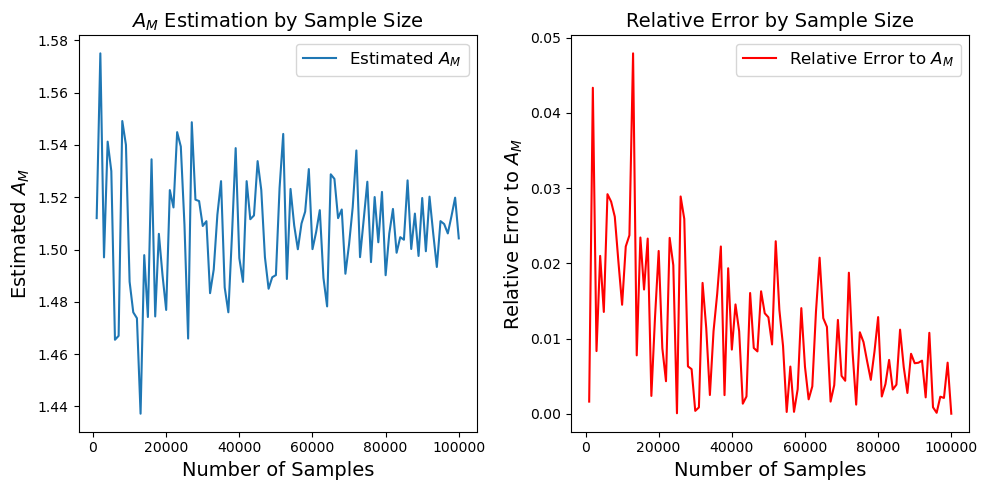

In [209]:
# Plotting the results
plt.figure(figsize=(10, 5))

# Plot Am estimations
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, Am_estimations, label=r'Estimated $A_M$')
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel(r'Estimated $A_M$', fontsize=14)
plt.title(r'$A_M$ Estimation by Sample Size', fontsize=14)
plt.legend(fontsize = 12)



# Plot relative errors
plt.subplot(1, 2, 2)
plt.plot(sample_sizes, relative_errors, label=r'Relative Error to $A_M$', color='red')
plt.xlabel('Number of Samples',  fontsize=14)
plt.ylabel(r'Relative Error to $A_M$', fontsize=14)
plt.title('Relative Error by Sample Size', fontsize=14)
plt.legend(fontsize = 12)

plt.tight_layout()
plt.savefig("2.2 different s.jpg", dpi = 300)
plt.show()


Too much stochasticity.

### Find s using confidence interval(significance level = 99%)
For each s, we run n times(n>30) and we apply CLT to calculate how certain We are the $A_M$ will fall within the confidence interval.


In [210]:
# Define the function to encapsulate the confidence interval calculation
def calculate_confidence_intervals(sampling_method, sample_sizes, real_range, imag_range, n, max_iter):
    conf_interval_radii = []
    mean_areas = []
    times = [] # stores the time each s used to calculate the confidence intervals and sample mean values
    
    # Perform the area estimation for each sample size
    for s in sample_sizes:
        start_time = time()  # start time
        area_estimates = []

        for _ in range(n):
            samples = sampling_method(s, real_range, imag_range)
            area = estimate_area(samples, max_iter)
            area_estimates.append(area)

        # Calculate the mean and standard deviation of the area estimates
        mean_area_estimated = np.mean(area_estimates)
        mean_areas.append(mean_area_estimated)
        std_area_estimated = np.std(area_estimates, ddof=1)

        # Calculate the 99% confidence interval radius
        z_score = norm.ppf(0.995)
        conf_radius = z_score * (std_area_estimated / np.sqrt(n))
        conf_interval_radii.append(conf_radius)

        end_time = time()  # end time
        times.append(end_time - start_time)  # compute the time

    return np.array(conf_interval_radii), np.array(mean_areas), np.array(times)


In [215]:
# Example usage
sample_sizes = np.arange(1000, 25000, 1000)
n = 50  # number of times to sample for each sample size

# Calculate confidence intervals for pure random sampling
conf_intervals_pure_random, mean_areas_random, times_pure_random = calculate_confidence_intervals(
    pure_random_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

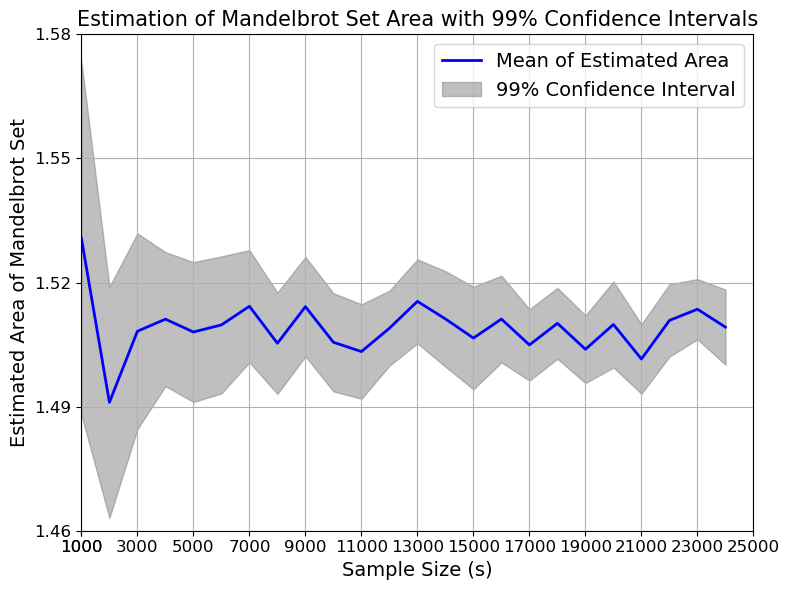

In [216]:
# Plot the estimated area and confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, mean_areas_random, label='Mean of Estimated Area', color='blue', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_random - conf_intervals_pure_random, 
                 mean_areas_random + conf_intervals_pure_random, color='gray', alpha=0.5, 
                 label='99% Confidence Interval')

# Set chart title and labels with specified font sizes
plt.title('Estimation of Mandelbrot Set Area with 99% Confidence Intervals', fontsize=15)
plt.xlabel('Sample Size (s)', fontsize=14)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=14)

# Specify font sizes for legend and grid
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)

# Set the x and y axis limits to ensure the origin is shown
plt.xlim(left=sample_sizes[0], right=sample_sizes[-1])
plt.ylim(bottom=min(mean_areas_random - conf_intervals_pure_random), top=max(mean_areas_random + conf_intervals_pure_random))

# Customize the tick marks font size and set specific ticks on x-axis
ax = plt.gca()  # Get the current Axes instance
ax.set_xticks([sample_sizes[0]] + list(range(1000, sample_sizes[-1]+2000, 2000)))  # Set specific x-ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], num=5))  # Set y-ticks to be less dense

# Customize the tick labels font size
ax.tick_params(axis='x', labelsize=12)  # Smaller font size for x-ticks
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("2.3 mean value and confidence intervals.jpg", dpi=300)
plt.show()

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/2025483301.py:63: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x16ad1a7d0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/2025483301.py:63: UserWarning: The label '_child2' of <matplotlib.lines.Line2D object at 0x16acf8d10> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/2025483301.py:63: UserWarning: The label '_child4' of <matplotlib.lines.Line2D object at 0x16abb0390> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize=14)
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_81798/2025483301.py:63: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x16a9928d0> starts with '_'. It is thus excluded from the l

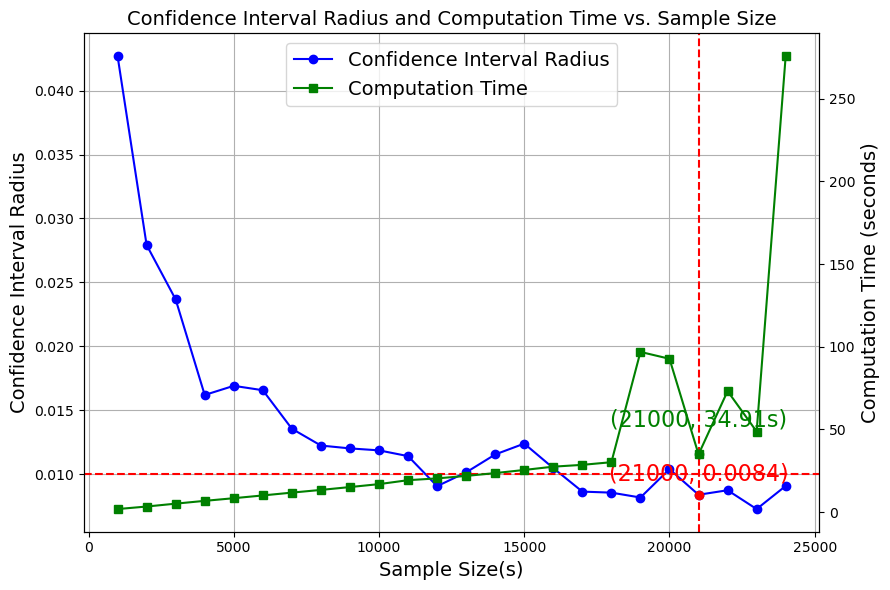

In [221]:
def mark_min_confidence_interval_time(ax, ax2, sample_sizes, conf_intervals, times, threshold, notationcolorx='r', notationcolory='g'):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return

    # Find the first index that satisfies the condition and ensure that all subsequent sample sizes also satisfy the condition
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_s_index = idx
            break
    else:
        print("No consecutive sample sizes meet the criterion.")
        return

    min_s = sample_sizes[min_s_index]
    min_conf_interval = conf_intervals[min_s_index]
    min_time = times[min_s_index]

    ax.plot(min_s, min_conf_interval, notationcolorx+'o')  # Mark with circle
    ax.annotate(f'({min_s}, {min_conf_interval:.4f})', 
                 (min_s, min_conf_interval), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 fontsize=16,
                 ha='center',
                 color=notationcolorx)
    # Draw a vertical dashed line at the minimum sample size
    ax.axvline(x=min_s, color=notationcolorx, linestyle='--')

    # Mark the computation time at the minimum sample size
    ax2.plot(min_s, min_time, notationcolory+'o')  # Mark with circle
    ax2.annotate(f'({min_s}, {min_time:.2f}s)', 
                (min_s, min_time), 
                textcoords="offset points", 
                xytext=(0,20), 
                fontsize=16,
                ha='center',
                color=notationcolory)

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(9, 6))
threshold = 0.01

# Plot the confidence interval on ax1
ax1.plot(sample_sizes, conf_intervals_pure_random, marker='o', label='Confidence Interval Radius', color='blue')
ax1.axhline(y=threshold, color='red', linestyle='--')
ax1.set_xlabel('Sample Size(s)', fontsize=14)
ax1.set_ylabel('Confidence Interval Radius', fontsize=14)
ax1.set_title('Confidence Interval Radius and Computation Time vs. Sample Size', fontsize=14)

# Use another y-axis for the computation time
ax2 = ax1.twinx()  
ax2.plot(sample_sizes, times_pure_random, marker='s', label='Computation Time', color='green')
ax2.set_ylabel('Computation Time (seconds)', fontsize=14)

# Mark the minimum confidence interval that meets the threshold
mark_min_confidence_interval_time(ax1, ax2, sample_sizes, conf_intervals_pure_random, times_pure_random, threshold)

# Handle legends for both axes
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=14)

ax1.grid(True)
plt.tight_layout()
plt.savefig("2.4 confidence_interval_and_time_combined.jpg", dpi=300)
plt.show()


Make n = [30,50,100]

In [329]:
sample_sizes = np.arange(1000, 20001, 1000)
n_values = [30, 50, 100]
real_range = (-2, 1)
imag_range = (-1.5, 1.5)

# Pre-calculate confidence intervals and mean areas for different values of n
results_dict = {}

for n_val in n_values:
    conf_intervals, mean_areas, times = calculate_confidence_intervals(
        pure_random_sampling, sample_sizes, real_range, imag_range, n_val, max_iter
    )
    results_dict[n_val] = {
        'conf_intervals': conf_intervals,
        'mean_areas': mean_areas,
        'times': times
    }

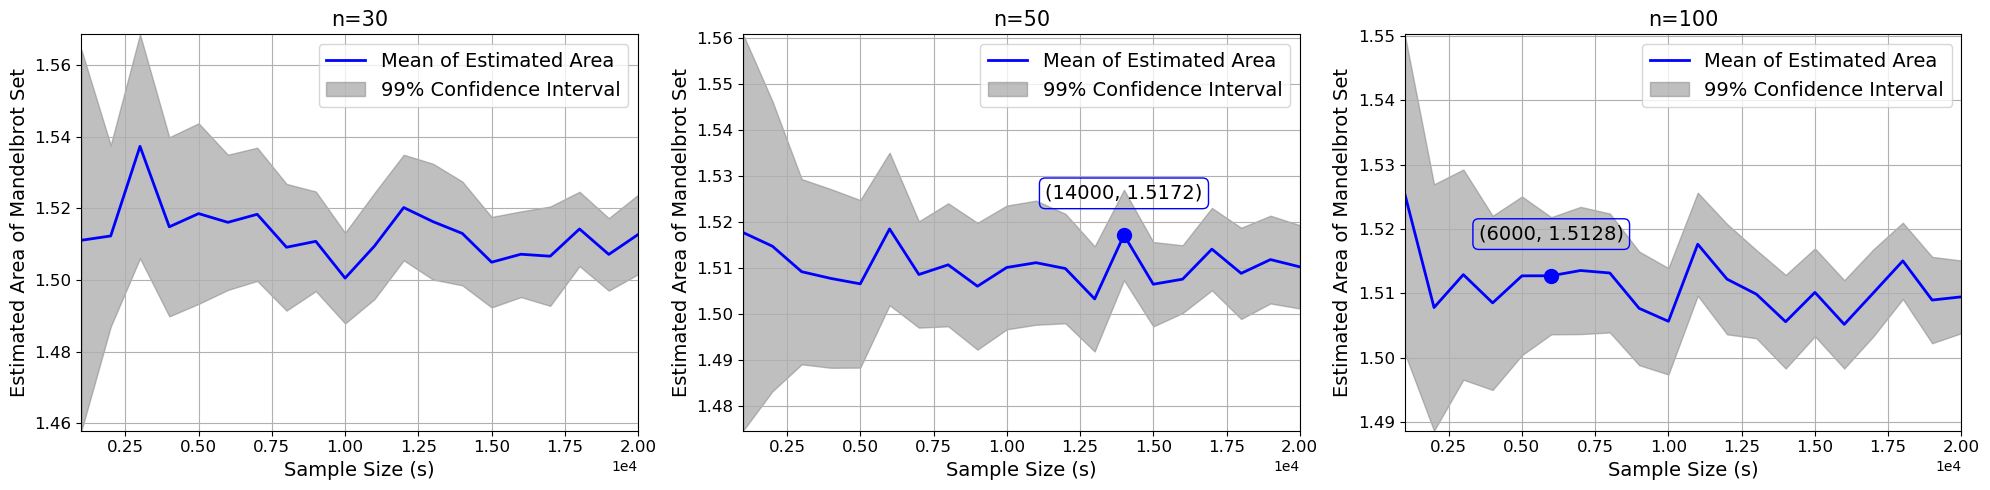

In [337]:
# Define the function to find the minimum sample size where the confidence interval is below the threshold
def find_min_confidence_interval_mean(sample_sizes, conf_intervals, mean_areas, threshold=0.001):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        return None, None  # Return None if no valid index found
    # Find the first occurrence where all subsequent conf_intervals are below the threshold
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            return sample_sizes[idx], mean_areas[idx]
    return None, None

# Define the function to mark the points on the plot
def mark_point(ax, x, y, color='r', text_offset=(0, 0)):
    ax.plot(x, y, 'o', color=color, markersize=10)
    ax.annotate(f'({x}, {y:.4f})', 
                xy=(x, y), 
                xytext=text_offset,
                textcoords="offset points",
                fontsize=14,
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='none'))
    
# Setting up the plot for 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# We'll store the axis objects in a dictionary for easy access
axes_dict = {n: ax for n, ax in zip(n_values, axs)}

# Define thresholds
thresholds = 0.01

# Plot for different values of n using the pre-calculated results
for n_val, ax in axes_dict.items():
    # Retrieve pre-calculated data
    conf_intervals = results_dict[n_val]['conf_intervals']
    mean_areas = results_dict[n_val]['mean_areas']
    times = results_dict[n_val]['times']  # not used in plotting

    ax.plot(sample_sizes, mean_areas, label='Mean of Estimated Area', color='blue', linewidth=2)
    ax.fill_between(sample_sizes, mean_areas - conf_intervals, 
                    mean_areas + conf_intervals, color='gray', alpha=0.5, 
                    label='99% Confidence Interval')

    # Plot the confidence intervals and annotate the mean for each sampling method
   
    min_s, min_mean = find_min_confidence_interval_mean(sample_sizes, conf_intervals, mean_areas, threshold)
        
    # Check if the points were found and then annotate them on the plot
    if min_s is not None:
        threshold_label = f'Threshold {threshold}'
        mark_point(ax, min_s, min_mean, color='blue', text_offset=(0, 30))

    # Set chart title and labels with specified font sizes
    ax.set_title(f'n={n_val}', fontsize=15)
    ax.set_xlabel('Sample Size (s)', fontsize=14)
    ax.set_ylabel('Estimated Area of Mandelbrot Set', fontsize=14)

    # Specify font sizes for legend and grid
    ax.legend(loc='upper right', fontsize=14)
    ax.grid(True)

    # Set the x and y axis limits
    ax.set_xlim(left=sample_sizes[0], right=sample_sizes[-1])
    ax.set_ylim(bottom=np.min(mean_areas - conf_intervals), top=np.max(mean_areas + conf_intervals))

    # Set the x-axis to use a scientific notation
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    # Customize the tick labels font size
    ax.tick_params(axis='x', labelsize=12)  # Smaller font size for x-ticks
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("2.9_mean_value_and_confidence_intervals_1x4_sci_separated.jpg", dpi=300)
plt.show()

No sample size meets the criterion.


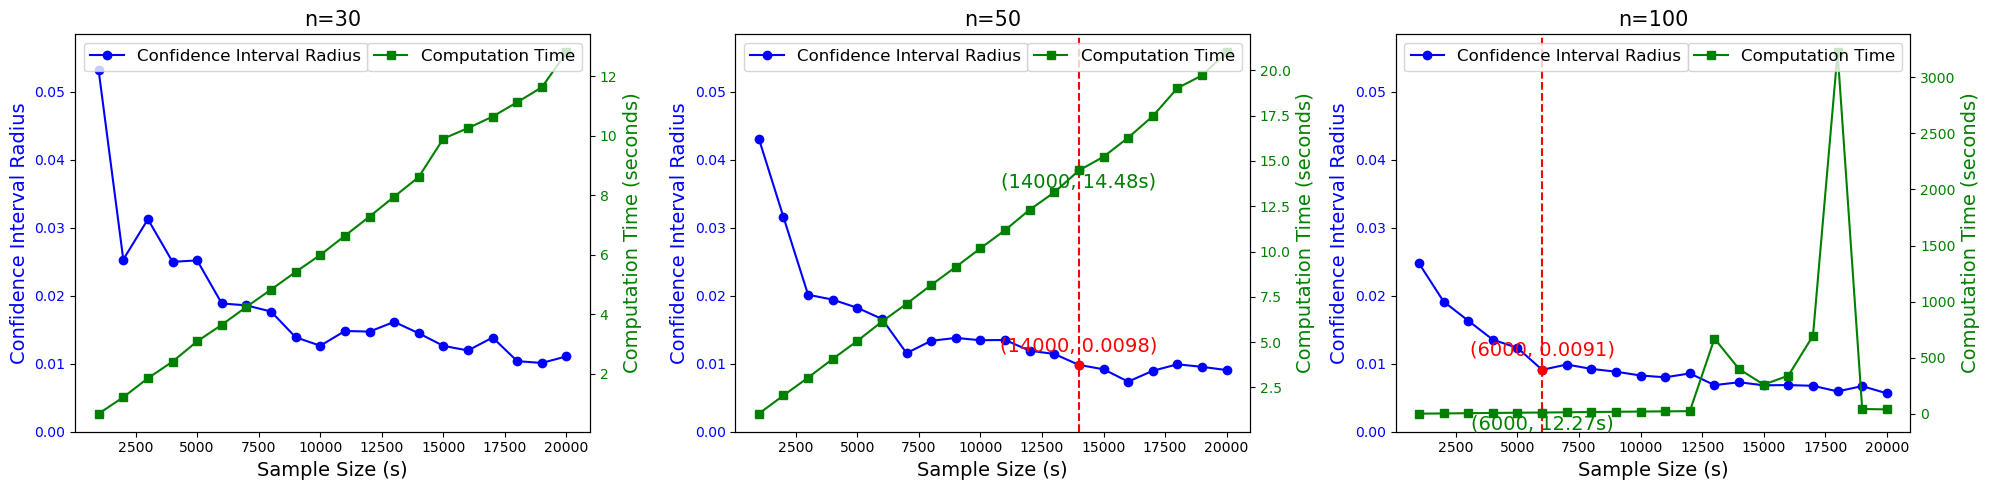

In [343]:
# Function to find the minimum sample size where the confidence interval is below the threshold
def find_min_confidence_interval_time(sample_sizes, conf_intervals, times, threshold=0.001):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return None, None, None  # Return None if no valid index found

    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_s_index = idx
            break
    else:  # If no break occurred in the loop
        return None, None, None

    min_s = sample_sizes[min_s_index]
    min_conf_interval = conf_intervals[min_s_index]
    min_time = times[min_s_index]
    return min_s, min_conf_interval, min_time

# Modified function to mark minimum confidence interval time on the plots
def mark_min_confidence_interval_time(ax, ax2, sample_sizes, conf_intervals, times, threshold, notationcolorx='r', notationcolory='g'):
    min_s, min_conf_interval, min_time = find_min_confidence_interval_time(sample_sizes, conf_intervals, times, threshold)

    if min_s is None:
        return

    # Mark and annotate the point on the confidence interval plot
    ax.plot(min_s, min_conf_interval, 'o', color=notationcolorx)
    ax.annotate(f'({min_s}, {min_conf_interval:.4f})', (min_s, min_conf_interval),
                textcoords="offset points", xytext=(0,10), ha='center', color=notationcolorx, fontsize=14)

    # Draw a vertical line on the plot for minimum sample size
    ax.axvline(x=min_s, color=notationcolorx, linestyle='--')

    # Mark and annotate the point on the computation time plot
    ax2.plot(min_s, min_time, 'o', color=notationcolory)
    ax2.annotate(f'({min_s}, {min_time:.2f}s)', (min_s, min_time),
                 textcoords="offset points", xytext=(0,-12), ha='center', color=notationcolory, fontsize=14)

# Sample sizes and threshold for marking
sample_sizes = np.arange(1000, 20001, 1000)
threshold = 0.01

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting the results
for i, (n_val, ax) in enumerate(zip([30, 50, 100], axs)):
    # Extract the results for the current n_val
    results = results_dict[n_val]
    conf_intervals = results['conf_intervals']
    times = results['times']

    # Create secondary axis for computation time
    ax2 = ax.twinx()

    # Plot confidence interval radius and computation time
    ax.plot(sample_sizes, conf_intervals, 'o-', label='Confidence Interval Radius', color='blue')
    ax2.plot(sample_sizes, times, 's-', label='Computation Time', color='green')

    # Mark the minimum confidence interval time
    mark_min_confidence_interval_time(ax, ax2, sample_sizes, conf_intervals, times, threshold)

    # Set titles and labels
    ax.set_title(f'n={n_val}', fontsize=15)
    ax.set_xlabel('Sample Size (s)', fontsize=14)
    ax.set_ylabel('Confidence Interval Radius', color='blue', fontsize=14)
    ax2.set_ylabel('Computation Time (seconds)', color='green', fontsize=14)
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='green')

    # Set the same y-axis limits for confidence interval radius across all subplots for comparison
    ax.set_ylim(0, max([max(res['conf_intervals']) for res in results_dict.values()]) * 1.1)

    
    ax.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig("2.11 n_varies.jpg", dpi = 300)
plt.show()

### Question 3: Use other sampling methods and run comparative analysis

In [ ]:
def latin_hypercube_sampling(num_samples, real_range, imag_range):
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d = 2)  # We have two dimensions: real and imaginary
    sample = sampler.random(n = num_samples)
    # Scale the sample to the specified ranges
    real_samples = qmc.scale(sample[:, [0]], real_range[0], real_range[1])
    imag_samples = qmc.scale(sample[:, [1]], imag_range[0], imag_range[1])
    # Combine real and imaginary parts into a 1D array of complex numbers
    complex_samples = real_samples.flatten() + 1j * imag_samples.flatten()
    return complex_samples

def orthogonal_sampling(num_samples, real_range, imag_range):
    # Create an Orthogonal Sampler
    sampler = qmc.LatinHypercube(d = 2, strength = 2)
    sample = sampler.random(n = num_samples)
    # Scale the sample to the specified ranges
    real_samples = qmc.scale(sample[:, [0]], real_range[0], real_range[1])
    imag_samples = qmc.scale(sample[:, [1]], imag_range[0], imag_range[1])
    # Combine real and imaginary parts into a 1D array of complex numbers
    complex_samples = real_samples.flatten() + 1j * imag_samples.flatten()
    return complex_samples

def sieve_of_eratosthenes(n):
    """Return an array of prime numbers up to n."""
    sieve = np.ones(n + 1, dtype=bool)
    sieve[:2] = False  # 0 and 1 are not prime numbers
    for i in range(2, int(n ** 0.5) + 1):
        if sieve[i]:
            sieve[i*i:n+1:i] = False
    return np.nonzero(sieve)[0]


#### Plot the confidence interval of these 3 sampling methods. Compare the convergence.

In [297]:
# Generate a large enough array of prime numbers since orthogonal_sampling only takes prime number's square as sample size
base_numbers = sieve_of_eratosthenes(110)[9:-1]  # Adjust the number here based on how many primes you need.107th prime number = 
# Square each number to get the sample sizes
sample_sizes = base_numbers**2

# Example usage with pure_random_sampling as the sampling method
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
# Calculate the total area of the complex plane region being considered 
total_area = (real_range[1] - real_range[0]) * (imag_range[1] - imag_range[0])
n = 100  # number of times to sample for each sample size

# Calculate confidence intervals and mean areas for each sampling method
conf_intervals_random, mean_areas_random, times_pure_random = calculate_confidence_intervals(
    pure_random_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

conf_intervals_latin, mean_areas_latin, times_latin = calculate_confidence_intervals(
    latin_hypercube_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

conf_intervals_orthogonal, mean_areas_orthogonal, times_orthogonal = calculate_confidence_intervals(
    orthogonal_sampling, sample_sizes, real_range, imag_range, n, max_iter
)

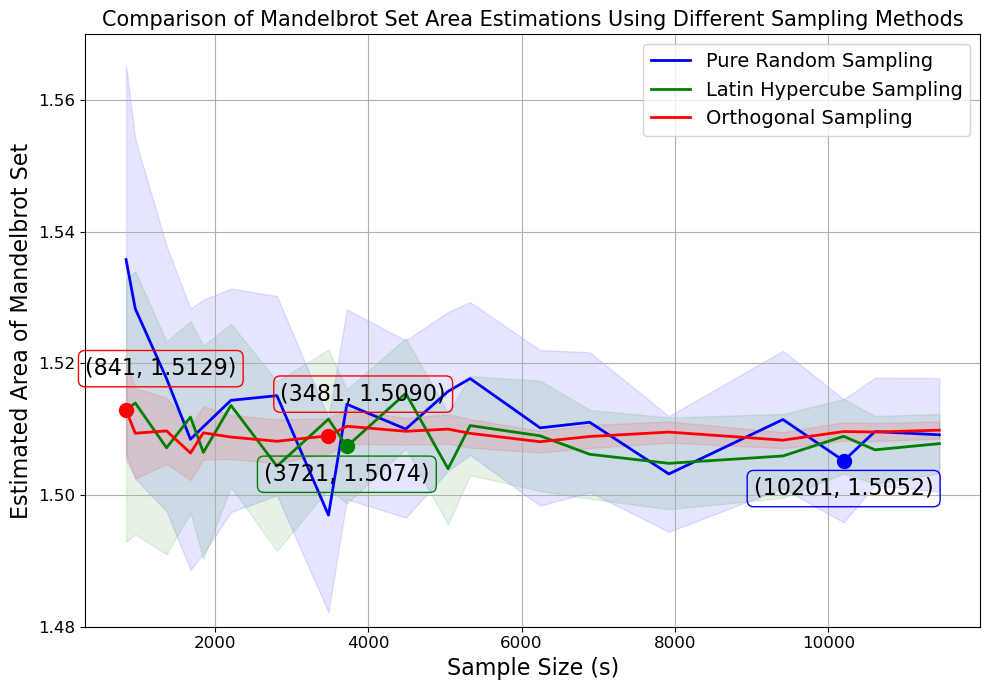

In [310]:

# Assuming the arrays 'sample_sizes', 'mean_areas_random', 'conf_intervals_random', 
# 'mean_areas_latin', 'conf_intervals_latin', 'mean_areas_orthogonal', and 'conf_intervals_orthogonal'
# are defined somewhere above this code snippet

def find_min_confidence_interval_mean(sample_sizes, conf_intervals, mean_areas, threshold=0.001):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        return None, None  # Return None if no valid index found
    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            return sample_sizes[idx], mean_areas[idx]
    return None, None

def mark_point(ax, x, y, color='r', text_offset=(0, 0)):
    ax.plot(x, y, 'o', color=color, markersize=10)
    ax.annotate(f'({x}, {y:.4f})', 
                xy=(x, y), 
                xytext=text_offset,
                textcoords="offset points",
                fontsize=16,
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='none'))

# Define thresholds
thresholds = [0.01, 0.003]

# Create the plot
plt.figure(figsize=(10, 7))

# Plot for Pure Random Sampling
plt.plot(sample_sizes, mean_areas_random, label='Pure Random Sampling', color='blue', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_random - conf_intervals_random, mean_areas_random + conf_intervals_random,
                 color='blue', alpha=0.1)

# Plot for Latin Hypercube Sampling
plt.plot(sample_sizes, mean_areas_latin, label='Latin Hypercube Sampling', color='green', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_latin - conf_intervals_latin, mean_areas_latin + conf_intervals_latin,
                color='green', alpha=0.1)

# Plot for Orthogonal Sampling
plt.plot(sample_sizes, mean_areas_orthogonal, label='Orthogonal Sampling', color='red', linewidth=2)
plt.fill_between(sample_sizes, mean_areas_orthogonal - conf_intervals_orthogonal, mean_areas_orthogonal + conf_intervals_orthogonal,
                color='red', alpha=0.1)
# Plot the confidence intervals for each sampling method
for threshold in thresholds:
    min_s_random, min_mean_random = find_min_confidence_interval_mean(sample_sizes, conf_intervals_random, mean_areas_random, threshold)
    min_s_latin, min_mean_latin = find_min_confidence_interval_mean(sample_sizes, conf_intervals_latin, mean_areas_latin, threshold)
    min_s_orthogonal, min_mean_orthogonal = find_min_confidence_interval_mean(sample_sizes, conf_intervals_orthogonal, mean_areas_orthogonal, threshold)

    # Check if the points were found and then annotate them on the plot
    if min_s_random is not None:
        mark_point(plt, min_s_random, min_mean_random, color='blue', text_offset=(0, -20))
    if min_s_latin is not None:
        mark_point(plt, min_s_latin, min_mean_latin, color='green', text_offset=(0, -20))
    if min_s_orthogonal is not None:
        mark_point(plt, min_s_orthogonal, min_mean_orthogonal, color='red', text_offset=(25, 30))

# Set chart title and labels
plt.title('Comparison of Mandelbrot Set Area Estimations Using Different Sampling Methods', fontsize=15)
plt.xlabel('Sample Size (s)', fontsize=16)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(1.48, 1.57)
plt.tight_layout()
plt.savefig("3.1_Ais_complete.jpg", dpi=300)
plt.show()




No sample size meets the criterion.
No sample size meets the criterion.


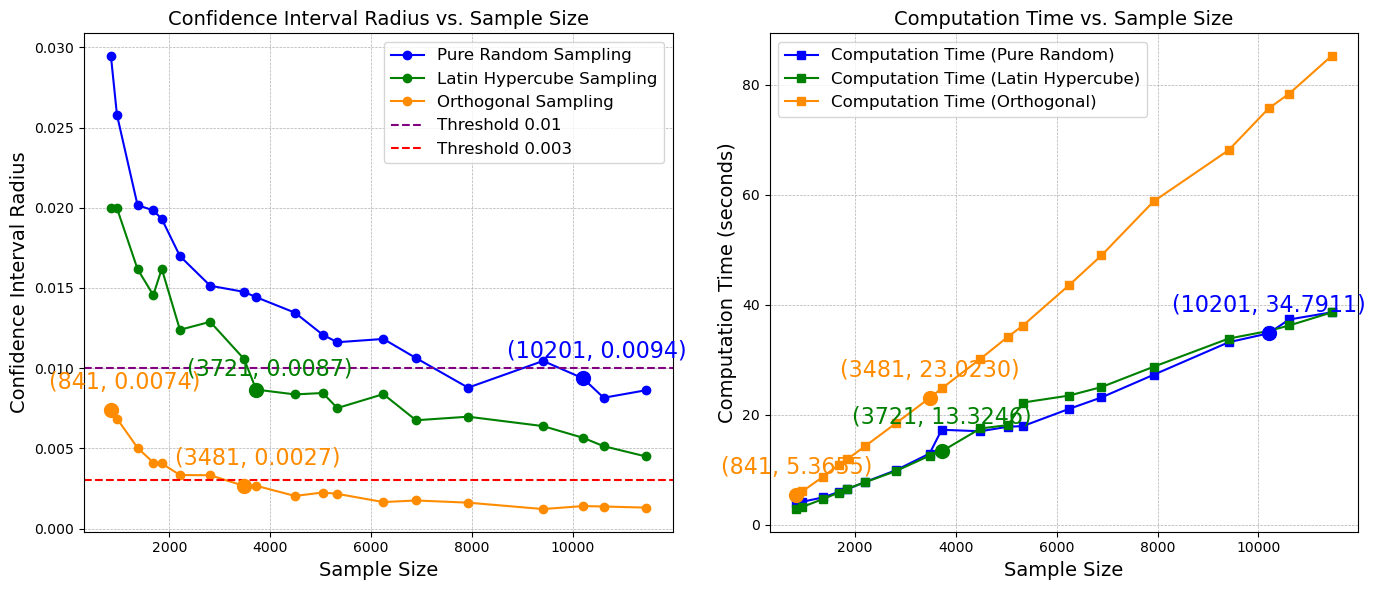

In [316]:
def find_min_confidence_interval_time(sample_sizes, conf_intervals, times, threshold=0.001):
    valid_indices = np.where(conf_intervals < threshold)[0]
    if valid_indices.size == 0:
        print("No sample size meets the criterion.")
        return None, None, None  # Return None if no valid index found

    for idx in valid_indices:
        if all(conf_intervals[idx:] < threshold):
            min_s_index = idx
            break
    else:  # If no break occurred in the loop
        return None, None, None

    min_s = sample_sizes[min_s_index]
    min_conf_interval = conf_intervals[min_s_index]
    min_time = times[min_s_index]
    return min_s, min_conf_interval, min_time

def mark_point(ax, x, y, color='r', label=None, text_offset=(0,10)):
    ax.plot(x, y, 'o', color=color, markersize=10)
    ax.annotate(f'({x}, {y:.4f})', 
                (x, y), 
                textcoords="offset points", 
                xytext=text_offset, 
                fontsize=16,
                ha='center',
                color=color)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))  # ax2 will be used for times

# Define the thresholds
thresholds = [0.01, 0.003]

# Plot the confidence intervals for each sampling method on ax1
ax1.plot(sample_sizes, conf_intervals_random, marker='o', label='Pure Random Sampling', color='blue')
ax1.plot(sample_sizes, conf_intervals_latin, marker='o', label='Latin Hypercube Sampling', color='green')
ax1.plot(sample_sizes, conf_intervals_orthogonal, marker='o', label='Orthogonal Sampling', color='darkorange')

# Set labels and title for ax1
ax1.set_xlabel('Sample Size', fontsize=14)
ax1.set_ylabel('Confidence Interval Radius', fontsize=14)
ax1.set_title('Confidence Interval Radius vs. Sample Size', fontsize=14)

# Plot the computation times on ax2
ax2.plot(sample_sizes, times_pure_random, marker='s', label='Computation Time (Pure Random)', color='blue')
ax2.plot(sample_sizes, times_latin, marker='s', label='Computation Time (Latin Hypercube)', color='green')
ax2.plot(sample_sizes, times_orthogonal, marker='s', label='Computation Time (Orthogonal)', color='darkorange')
ax2.set_title('Computation Time vs. Sample Size', fontsize=14)

# Set labels for ax2
ax2.set_ylabel('Computation Time (seconds)', fontsize=14)
ax2.set_xlabel('Sample Size', fontsize=14)

# Plot threshold lines and find the minimum s for each threshold
for threshold in thresholds:
    ax1.axhline(y=threshold, color='red' if threshold == 0.003 else 'purple', linestyle='--', label=f'Threshold {threshold}')

    # Pure Random Sampling
    min_s_random, min_conf_interval_random, min_time_random = find_min_confidence_interval_time(
        sample_sizes, conf_intervals_random, times_pure_random, threshold
    )
    if min_s_random is not None:
        mark_point(ax1, min_s_random, min_conf_interval_random, color='blue', text_offset=(10, 15))
        mark_point(ax2, min_s_random, min_time_random, color='blue', text_offset=(0, 15))

    # Latin Hypercube Sampling
    min_s_latin, min_conf_interval_latin, min_time_latin = find_min_confidence_interval_time(
        sample_sizes, conf_intervals_latin, times_latin, threshold
    )
    if min_s_latin is not None:
        mark_point(ax1, min_s_latin, min_conf_interval_latin, color='green', text_offset=(10, 10))
        mark_point(ax2, min_s_latin, min_time_latin, color='green', text_offset=(0, 20))

    # Orthogonal Sampling
    min_s_orthogonal, min_conf_interval_orthogonal, min_time_orthogonal = find_min_confidence_interval_time(
        sample_sizes, conf_intervals_orthogonal, times_orthogonal, threshold
    )
    if min_s_orthogonal is not None:
        mark_point(ax1, min_s_orthogonal, min_conf_interval_orthogonal, color='darkorange', text_offset=(10, 15))
        mark_point(ax2, min_s_orthogonal, min_time_orthogonal, color='darkorange', text_offset=(0, 15))

# Add legends and set up the grid for both subplots
ax1.legend(loc='upper right', fontsize=12)
ax2.legend(loc='upper left', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save and show the figure
plt.tight_layout()
plt.savefig("3.3_confidence_interval_and_time.png", dpi=300)
plt.show()



In [ ]:
print(conf_intervals_orthogonal)

[0.04451405 0.02824473 0.02311004 0.01424471 0.01198168 0.0085604
 0.0069296  0.00627299 0.00484542 0.00436834 0.00377767 0.00351815
 0.00278424 0.0029891  0.00246712 0.00196454 0.00203458 0.00220201
 0.00181887 0.00185083 0.00148467 0.00125045 0.00121792 0.0011724
 0.00138152 0.00115855 0.00106333 0.0008823  0.00092576 0.00086738
 0.00074521]


#### Plot the relative error using 3 methods. Compare the curve and the min s.

Now we define relative_error as Ais/Am to see how the sampling method influence the Ais.

Now we take each(i,s) combination for repetitions to simulate the variance and mean.

### Other things we tried to do in Q2 and Q3:
- T test.
  
  For a given sample point, there are two possible states: either the point lies within the Mandelbrot set, denoted as 1, or it does not, denoted as 0. For a set of sample points, the sample mean is denoted as: 
\begin{equation}
    \bar{X} = p
\end{equation}
And the standard deviation of the sample mean is given by 
\begin{equation}
    \frac{S}{\sqrt{n}} = \sqrt{\frac{p(1-p)}{s}}
\end{equation}
The true mean is denoted by 
\begin{equation}
    \theta = \frac{A_M}{9} 
\end{equation}
where $A_M$ is defined as the biggest i and biggest s we can use(computation time acceptable) to calculate the $A_{is}$.
According to the Central Limit Theorem, the standardized variable $\frac{\bar{X} - \theta}{\sigma/\sqrt{n}}$ follows a T distribution with the freedom of s-1.
- Difine \varepsilon = confidence interval raidus / mean value of samples. Study how this relative error changes when increasing s.

They are all based on we have the $A_M$ as defined by the biggest i and biggest s we can use(computation time acceptable) to calculate the $A_{is}$, which turns out to be not the main target for our assignment. But we did spend a lot of time on doing things above.